<a href="https://colab.research.google.com/github/mohamed-stifi/Moroccan-Money-detection/blob/main/Moroccan_Money_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import the necessary libraries

In [68]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(43)

## Access to Kaggle datasets

In [ ]:
!pip install kaggle

In [3]:
from google.colab import files

# Upload the Kaggle API credentials file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d oussamaouardini/moroccan-money-dataset

 47% 3.00M/6.38M [00:00<00:00, 5.58MB/s]
100% 6.38M/6.38M [00:00<00:00, 8.82MB/s]


In [ ]:
!unzip moroccan-money-dataset.zip

In [8]:
!ls

'Moroccan Money dataset'   moroccan-money-dataset.zip   sample_data


## Load dataset

In [61]:
dataset_path = '/content/Moroccan Money dataset/'

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to a common size
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image pixel values
])

dataset = datasets.ImageFolder(root=dataset_path , transform=transform)

dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


classes  = dataset.classes


In [62]:
class_name = [class_ + " DH" for class_ in classes]
print("classes names ", class_name)

classes names  ['0.1 DH', '0.2 DH', '0.5 DH', '1 DH', '10 DH', '100 DH', '2 DH', '20 DH', '200 DH', '5 DH', '50 DH']


With this for loop, we can get the number of images per class in train and test data set.

In [63]:
train_class_count = {}
for _, index in train_dataset:
    label = class_name[index]
    if label not in train_class_count:
        train_class_count[label] = 0
    train_class_count[label] += 1
test_class_count = {}
for _, index in test_dataset:
    label = class_name[index]
    if label not in test_class_count:
        test_class_count[label] = 0
    test_class_count[label] += 1
print("train class count\n",train_class_count)
print("test class count\n",test_class_count)

train class count
 {'0.1 DH': 44, '0.2 DH': 34, '10 DH': 29, '5 DH': 27, '1 DH': 33, '20 DH': 25, '100 DH': 15, '0.5 DH': 33, '200 DH': 13, '50 DH': 19, '2 DH': 12}
test class count
 {'20 DH': 8, '0.1 DH': 11, '0.2 DH': 9, '50 DH': 2, '5 DH': 10, '1 DH': 7, '200 DH': 5, '2 DH': 3, '10 DH': 7, '100 DH': 6, '0.5 DH': 2}


Here, we can visualize a batch of data using the make_grid helper function from Torchvision.

images.shape: torch.Size([10, 3, 64, 64])
0.2 DH	|	0.1 DH	|	1 DH 	|	1 DH 	|	0.1 DH	|	20 DH	|	5 DH 	|	20 DH	|	0.1 DH	|	5 DH 


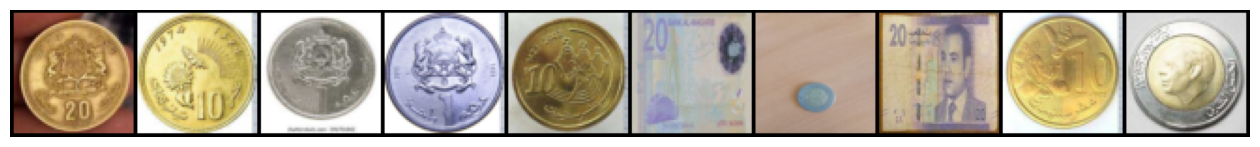

In [64]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    print('\t|\t'.join(f'{class_name[labels[j]]:5s}' for j in range(batch_size)))
    images = images/2 + 0.5   # unnormalize
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.xlabel(labels)
    break

images.shape: torch.Size([10, 3, 64, 64])
20 DH	|	0.1 DH	|	20 DH	|	20 DH	|	0.2 DH	|	50 DH	|	20 DH	|	0.2 DH	|	0.2 DH	|	0.2 DH


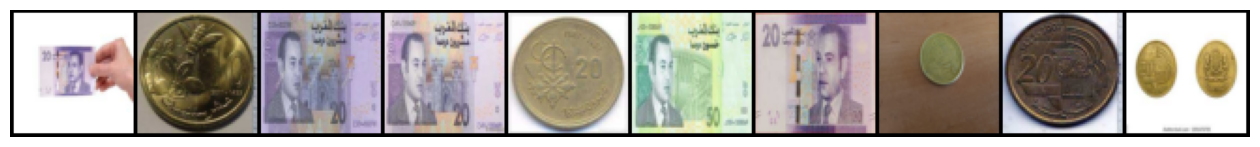

In [65]:
for images, labels in test_loader:
    print('images.shape:', images.shape)
    print('\t|\t'.join(f'{class_name[labels[j]]:5s}' for j in range(batch_size)))
    images = images/2 + 0.5   # unnormalize
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.xlabel(labels)
    break

##Build a CNN model for image classification

In [84]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("x sahpe : ", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [119]:
cnn = CNN()
num_epook = 1000
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

###train model

In [122]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [123]:
history = {"loss" : [], "accuracy" : []}
score = 0
loss_ = 0
total = 0
for epook  in  range(num_epook):
    for i, (imgs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outs = cnn(imgs)

        loss = Loss(outs, labels)
        loss.backward()
        optimizer.step()
        score += accuracy(outs, labels)
        loss_ += loss.item()
        total += 1
        if i % 10 == 0 and epook %100 == 0:
          print(f"epook [{epook}/{num_epook}] | i = {i} | loss = {loss.item()}")
    history['loss'].append(loss_/total)
    history['accuracy'].append(score/total)

epook [0/1000] | i = 0 | loss = 2.361701488494873
epook [0/1000] | i = 10 | loss = 2.407209873199463
epook [0/1000] | i = 20 | loss = 2.377821445465088
epook [100/1000] | i = 0 | loss = 0.294636070728302
epook [100/1000] | i = 10 | loss = 0.05968320369720459
epook [100/1000] | i = 20 | loss = 0.1948356330394745
epook [200/1000] | i = 0 | loss = 0.0026538907550275326
epook [200/1000] | i = 10 | loss = 0.004833404440432787
epook [200/1000] | i = 20 | loss = 0.03501655533909798
epook [300/1000] | i = 0 | loss = 0.019385753199458122
epook [300/1000] | i = 10 | loss = 0.00277776294387877
epook [300/1000] | i = 20 | loss = 0.00207628239877522
epook [400/1000] | i = 0 | loss = 0.00028370763175189495
epook [400/1000] | i = 10 | loss = 0.0017065105494111776
epook [400/1000] | i = 20 | loss = 0.0001731656666379422
epook [500/1000] | i = 0 | loss = 0.00018933045794256032
epook [500/1000] | i = 10 | loss = 7.469857519026846e-05
epook [500/1000] | i = 20 | loss = 8.669253293192014e-05
epook [600/10

### Save model

In [124]:
PATH = './Moroccan_Money_detection.pth'
torch.save(cnn.state_dict(), PATH)

##Evaluate model's performance on the test dataset

### Load model

In [125]:
M_Money = CNN()
M_Money.load_state_dict(torch.load(PATH))

<All keys matched successfully>

###Evaluate model

In [126]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = M_Money(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
print('True: ', ' '.join(f'{classes[labels[j]]:5s}'
                              for j in range(4)))

Predicted:  50    0.2   20    20   
True:  20    0.1   20    20   


In [137]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:

        outputs = M_Money(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 70 test images: 58 %


In [128]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_name}
total_pred = {classname: 0 for classname in class_name}


with torch.no_grad():
    for images, labels in test_loader:

        outputs = M_Money(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_name[label]] += 1
            total_pred[class_name[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0.1 DH is 54.5 %
Accuracy for class: 0.2 DH is 55.6 %
Accuracy for class: 0.5 DH is 50.0 %
Accuracy for class: 1 DH  is 57.1 %
Accuracy for class: 10 DH is 71.4 %
Accuracy for class: 100 DH is 66.7 %
Accuracy for class: 2 DH  is 33.3 %
Accuracy for class: 20 DH is 62.5 %
Accuracy for class: 200 DH is 40.0 %
Accuracy for class: 5 DH  is 60.0 %
Accuracy for class: 50 DH is 100.0 %


##Visualize the train of model

In [129]:
def plot_losses(history):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')

In [130]:
def plot_accuracies(history):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. No. of epochs')

In [139]:
loss = history["loss"]
score = history["accuracy"]
print(f'the last Accuracy of the network train images: {score[-1]:.2f} %')

the last Accuracy of the network train images: 0.96 %


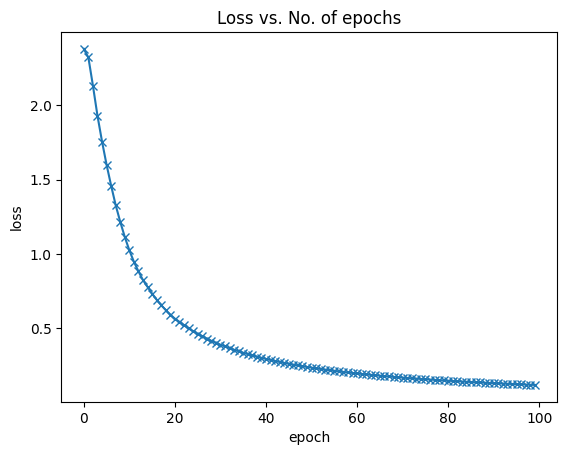

In [135]:
plot_losses(loss[::10])

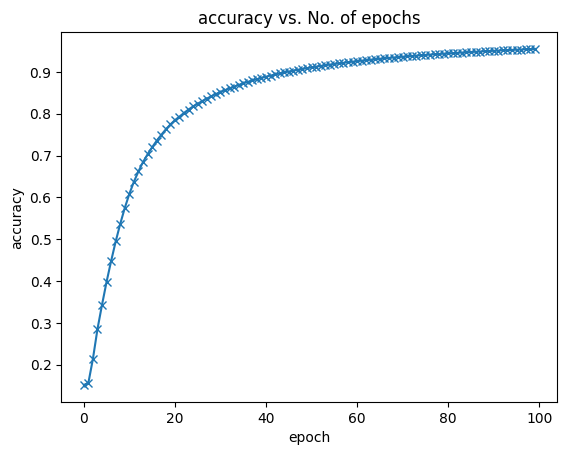

In [136]:
plot_accuracies(score[::10])